In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/tactile-paving/split-images/train", 
    target_size=(150, 150),
    batch_size=128,
    class_mode="binary"
)

validation_generator = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/tactile-paving/split-images/validation",
    target_size=(150, 150),
    batch_size=128,
    class_mode="binary"
)

Found 8002 images belonging to 2 classes.
Found 2798 images belonging to 2 classes.


In [4]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 3, activation="relu", input_shape = (150, 150, 3)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(64, 3, activation="relu"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(512, 3, activation="relu"),
    keras.layers.MaxPooling2D(2),
    # keras.layers.Conv2D(512, 3, activation="relu"),
    # keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 128)     

In [5]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    verbose=2
)

model.save_weights("/content/drive/MyDrive/tactile-paving/tactile-paving-2.h5")

Epoch 1/15


KeyboardInterrupt: ignored

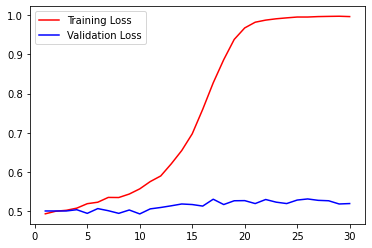

0.5134858230749766


In [28]:

loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1, len(history.history["accuracy"]) + 1)

plt.plot(epochs, loss, "r", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.legend()

plt.show()

print(sum(val_loss)/len(val_loss))

Overfitting *and* no statistical power! Damn.

In [7]:
from tensorflow.keras.applications import VGG16

In [8]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

new_model = keras.models.Sequential()
new_model.add(base_model)
new_model.add(keras.layers.Flatten())
new_model.add(keras.layers.Dense(512, activation="relu"))
new_model.add(keras.layers.Dense(1, activation="sigmoid"))

new_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 18,910,017
Non-trainable params: 0
_________________________________________________________________


In [9]:
base_model.trainable = False

new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
new_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

history = new_model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    verbose=2
)

new_model.save_weights("/content/drive/MyDrive/tactile-paving/tactile-paving_vgg16.h5")

Epoch 1/15
63/63 - 1225s - loss: 0.8036 - accuracy: 0.5489 - val_loss: 0.6970 - val_accuracy: 0.5382 - 1225s/epoch - 19s/step
Epoch 2/15
63/63 - 28s - loss: 0.6412 - accuracy: 0.6246 - val_loss: 0.6882 - val_accuracy: 0.5586 - 28s/epoch - 449ms/step
Epoch 3/15
63/63 - 28s - loss: 0.6111 - accuracy: 0.6580 - val_loss: 0.7522 - val_accuracy: 0.5397 - 28s/epoch - 449ms/step
Epoch 4/15
63/63 - 29s - loss: 0.5903 - accuracy: 0.6732 - val_loss: 0.7110 - val_accuracy: 0.5593 - 29s/epoch - 453ms/step
Epoch 5/15
63/63 - 28s - loss: 0.5592 - accuracy: 0.7081 - val_loss: 0.7270 - val_accuracy: 0.5604 - 28s/epoch - 446ms/step
Epoch 6/15
63/63 - 28s - loss: 0.5483 - accuracy: 0.7134 - val_loss: 0.7282 - val_accuracy: 0.5536 - 28s/epoch - 447ms/step
Epoch 7/15
63/63 - 28s - loss: 0.4987 - accuracy: 0.7572 - val_loss: 0.7420 - val_accuracy: 0.5636 - 28s/epoch - 447ms/step
Epoch 8/15
63/63 - 28s - loss: 0.4751 - accuracy: 0.7702 - val_loss: 0.7880 - val_accuracy: 0.5604 - 28s/epoch - 446ms/step
Epoch 

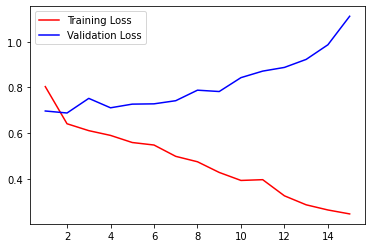

0.557564930121104


In [13]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(history.history["accuracy"]) + 1)

plt.plot(epochs, loss, "r", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.legend()

plt.show()

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

print(sum(val_accuracy)/len(val_accuracy))

Overfitting and *barely* statistical power.

# Next Steps:
- Try fine tuning VGG16 base model
- Try other base models
- Manually label and filter data to increase data quality